# MS1/MS2-based quantification of lipids bound to MlaC

In [1]:
import os
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.optimize import minimize
%matplotlib ipympl
matplotlib.rcParams['pdf.fonttype'] = 42

First, load the input files. These should be:
1. **ms1file**: deconvolved ms1 spectrum in which resolution is determined by the inherent peak width of the isotopic envelope
2. **lipidmassfile**: file used for calculating lipid masses
3. **ms2file**: paired ms2 file showing released lipids from protein. The script will need to be updated if the polarity is different.

In [2]:
ms1file = './exampleData/MS1.txt' 
lipidmassfile = './Lipidmasses.txt'
ms2file = './exampleData/MS2.txt' 

Next we load and plot the deconvolved MS1 spectrum, filtering to only include the specific mass region.

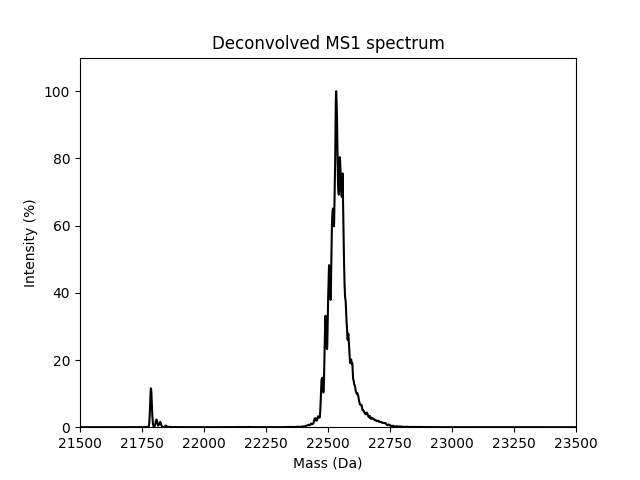

In [3]:
x_low = 21500
x_high = 23500
ms1_df = pd.read_csv(ms1file, sep=' ', names=['x', 'y'])
ms1_df['y'] = ms1_df['y'] / ms1_df['y'].max() * 100
reduced_ms1_df = ms1_df[(ms1_df['x'] >= x_low) & (ms1_df['x'] <= x_high)]  
plt.plot(reduced_ms1_df['x'], reduced_ms1_df['y'], color='black')
plt.xlim(x_low, x_high)
plt.ylim(0, 110)
plt.title('Deconvolved MS1 spectrum')
plt.xlabel('Mass (Da)')
plt.ylabel('Intensity (%)')
plt.show()

The next code block estimates a suitable PSF for the individual species in the spectrum. This is done by fitting the sum of individual modified forms of the protein e.g. oxidised. Each individual form is represented by a Gaussian where peak width is equal to that of the theoretical isotopic envelope.

Fitted Parameters:
Amplitude: 10.9176 ± 0.0221
Peak Center: 21786.2427 ± 0.0106
Oxidation +16: 0.0000 ± 0.0024
Oxidation +32: 0.0238 ± 0.0026
Sodium +22: 0.1942 ± 0.0025
Sodium +44: 0.0000 ± 0.0025
Oxidation+Sodium +38: 0.1265 ± 0.0030


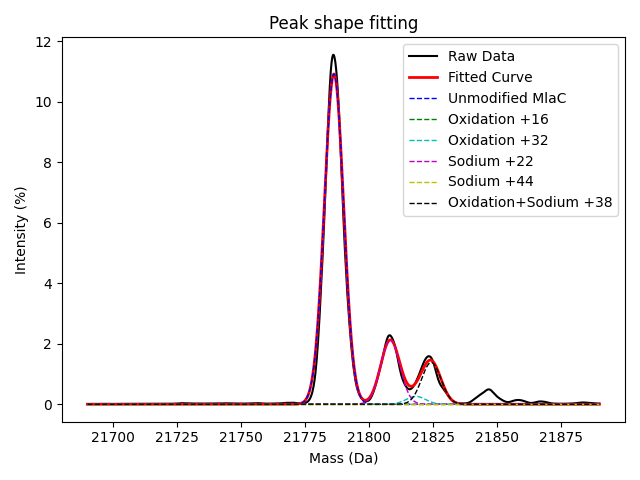

In [4]:
def peak_shape_function(x, a, b, d, e, f, g, h):
    """
    Generate a composite peak shape function representing a protein mass spectrum with various modifications.
    
    This function models a protein peak and its modified forms by combining multiple Gaussian distributions. 
    The modifications represented include oxidation states (+16, +32 Da), sodium adducts (+22, +44 Da), 
    and a combined oxidation-sodium adduct (+38 Da). More states can be added if required.
    
    Parameters:
    -----------
    x : array-like
        Mass-to-charge (m/z) values for which to calculate intensities
    a : float
        Amplitude/height of the base apoprotein peak
    b : float
        Center position (m/z) of the base apoprotein peak
    d : float
        Relative abundance of the first oxidation state (+16 Da) compared to apoprotein
    e : float
        Relative abundance of the second oxidation state (+32 Da) compared to apoprotein
    f : float
        Relative abundance of the first sodium adduct (+22 Da) compared to apoprotein
    g : float
        Relative abundance of the second sodium adduct (+44 Da) compared to apoprotein
    h : float
        Relative abundance of the combined oxidation-sodium adduct (+38 Da) compared to apoprotein
    
    Returns:
    --------
    array-like
        Combined intensity values representing the protein peak shape function.
        
    Notes:
    ------
    The width (c) of the Gaussian peaks is fixed at 3.7664, based on simulation of isotopic distribution
    for this particular system. This value may need adjustment for different protein systems.
    """
    c = 3.7664
    apo = a * np.exp(-((x - b) ** 2) / (2 * c ** 2)) 
    ox1 = a * d * np.exp(-((x - (b+16)) ** 2) / (2 * c ** 2)) 
    ox2 = a * e * np.exp(-((x - (b+32)) ** 2) / (2 * c ** 2)) 
    sod1 = a * f * np.exp(-((x - (b+22)) ** 2) / (2 * c ** 2))
    sod2 = a * g * np.exp(-((x - (b+44)) ** 2) / (2 * c ** 2))
    ox1sod1 = a * h * np.exp(-((x - (b+38)) ** 2) / (2 * c ** 2))
    return apo+ox1+ox2+sod1+sod2+ox1sod1


def fit_and_plot_peak(x_data, y_data, peak_center_guess):
    """
    Fit the above peak shape function to the data with positive bounds on all parameters
    
    Parameters:
    -----------
    x_data : array-like
        m/z values
    y_data : array-like
        intensity values
    peak_center_guess : float
        initial guess for the center of the main peak
        
    Returns:
    --------
    tuple
        (peak_center, fwhm) - The fitted peak center and full width at half maximum
    """

    initial_guesses = [
        max(y_data),             # a: amplitude
        peak_center_guess,       # b: peak center
        0.1,                     # d: relative abundance of first oxidation compared to apo
        0.05,                    # e: relative abundance of second oxidation compared to apo
        0.05,                    # f: relative abundance of first sodium adduct compared to apo
        0.05,                    # g: relative abundance of second sodium adduct compared to apo
        0.05                     # h: relative abundance of combined oxidation+sodium compared to apo
    ]
    
    # Define lower and upper bounds for all parameters
    # Format: ([lower_bounds], [upper_bounds])
    # Setting lower bounds to 0 ensures all parameters are positive
    lower_bounds = [0, peak_center_guess - 50, 0, 0, 0, 0, 0]
    upper_bounds = [np.inf, peak_center_guess + 50, 1, 1, 1, 1, 1]
    bounds = (lower_bounds, upper_bounds)
    
    popt, pcov = curve_fit(peak_shape_function, x_data, y_data, p0=initial_guesses, 
                          bounds=bounds, maxfev=10000)
    
    a, b, d, e, f, g, h = popt
    perr = np.sqrt(np.diag(pcov))
    param_names = ['Amplitude', 'Peak Center', 'Oxidation +16', 'Oxidation +32', 
                  'Sodium +22', 'Sodium +44', 'Oxidation+Sodium +38']
    print("Fitted Parameters:")
    for i, (name, val, err) in enumerate(zip(param_names, popt, perr)):
        print(f"{name}: {val:.4f} ± {err:.4f}")
    
    c = 3.7664  # fixed width parameter
    fwhm = c * 2.355

    x_fit = np.linspace(min(x_data), max(x_data), 1000)
    y_fit = peak_shape_function(x_fit, *popt)
    
    # calculate individual component peaks for the plot
    apo = a * np.exp(-((x_fit - b) ** 2) / (2 * c ** 2))
    ox1 = a * d * np.exp(-((x_fit - (b+16)) ** 2) / (2 * c ** 2))
    ox2 = a * e * np.exp(-((x_fit - (b+32)) ** 2) / (2 * c ** 2))
    sod1 = a * f * np.exp(-((x_fit - (b+22)) ** 2) / (2 * c ** 2))
    sod2 = a * g * np.exp(-((x_fit - (b+44)) ** 2) / (2 * c ** 2))
    ox1sod1 = a * h * np.exp(-((x_fit - (b+38)) ** 2) / (2 * c ** 2))

    plt.figure()
    plt.plot(x_data, y_data, 'k-', label='Raw Data')
    plt.plot(x_fit, y_fit, 'r-', linewidth=2, label='Fitted Curve')
    plt.plot(x_fit, apo, 'b--', linewidth=1, label='Unmodified MlaC')
    plt.plot(x_fit, ox1, 'g--', linewidth=1, label='Oxidation +16')
    plt.plot(x_fit, ox2, 'c--', linewidth=1, label='Oxidation +32')
    plt.plot(x_fit, sod1, 'm--', linewidth=1, label='Sodium +22')
    plt.plot(x_fit, sod2, 'y--', linewidth=1, label='Sodium +44')
    plt.plot(x_fit, ox1sod1, 'k--', linewidth=1, label='Oxidation+Sodium +38')
    
    plt.title(f'Peak shape fitting')
    plt.xlabel('Mass (Da)')
    plt.ylabel('Intensity (%)')
    plt.legend()
      
    plt.tight_layout()
    plt.show()


    params = [d,e,f,g,h]
    
    return b, fwhm, params

rough_peak_centers = [21790]
window = 100
for rough_peak_center in rough_peak_centers:
    # filter data to focus on the peak of interest
    peak_data = ms1_df[(ms1_df['x'] >= rough_peak_center - window) & 
                       (ms1_df['x'] <= rough_peak_center + window)]
    center, fwhm, params = fit_and_plot_peak(peak_data['x'], peak_data['y'], rough_peak_center)

peak_center = center

Extract intensities from the MS2 spectrum and use this to calculate intial guesses for fitting.

In [6]:
ms2_df = pd.read_csv(ms2file, sep='\t', header=None, names=['x', 'y'])
lipidmasses_df = pd.read_csv(lipidmassfile, sep='\t', header=None, names=['mass', 'chain'])

# get noise from empty area of spectrum (620-660)
noise_df = ms2_df[(ms2_df['x'] >= 640) & (ms2_df['x'] <= 650)]
noise_threshold = noise_df['y'].max() * 1.1

# get all peaks contained in the MS spectrum in the m/z range 660-820
ms2_x_min = 660
ms2_x_max = 820
reduced_ms2_df = ms2_df[(ms2_df['x'] >= ms2_x_min) & (ms2_df['x'] <= ms2_x_max)]

peaks, _ = find_peaks(reduced_ms2_df['y'], height=noise_threshold)
exp_peak_list = reduced_ms2_df.iloc[peaks][['x', 'y']] 

def intensity_picking(theomass, arg):
    nearest_mass = arg['x'].sub(theomass).abs().idxmin()
    if abs(arg.loc[nearest_mass, 'x'] - theomass) <= 0.15:
        index_list = arg.index.tolist()
        current_pos = index_list.index(nearest_mass)
        if current_pos == 0:
            return arg.loc[nearest_mass, 'y']
        else:
            if abs(arg.loc[index_list[current_pos - 1], 'x'] - arg.loc[index_list[current_pos], 'x']) <= 0.8:
                previous_index = index_list[current_pos - 2]
            else:
                previous_index = index_list[current_pos - 1]
            if abs(arg.loc[previous_index, 'x'] - theomass + 1) <= 0.1:
                expected_isotope = 0.011*40*arg.loc[previous_index, 'y']
                if arg.loc[nearest_mass, 'y'] > 1.1*expected_isotope:
                    return arg.loc[nearest_mass, 'y']
                else:
                    return 0
            else:
                return arg.loc[nearest_mass, 'y']
    else:
        return 0


overview_df = lipidmasses_df[['chain']].copy() 
overview_df['mz PG Na'] = lipidmasses_df['mass'] + 171.01 + 22.99  # mass of sodiated PGs
overview_df['mz PE Na'] = lipidmasses_df['mass'] + 140.01 + 22.99 # mass of sodiated PEs
overview_df['mz PE H'] = lipidmasses_df['mass'] + 141.02 # mass of protonated PEs
overview_df['PG intensity'] = overview_df['mz PG Na'].apply(intensity_picking, arg = exp_peak_list)
overview_df['PE intensity'] = overview_df['mz PE Na'].apply(intensity_picking, arg = exp_peak_list)+overview_df['mz PE H'].apply(intensity_picking, arg = exp_peak_list)
overview_df['complex mass PG'] = overview_df['mz PG Na'] - 22.99 + peak_center
overview_df['complex mass PE'] = overview_df['mz PE Na'] - 22.99 + peak_center

max_intensity = reduced_ms1_df['y'].max()
# Biggest peak in the MS1 typicallyy corresponds to a PG species
scaling_factor = max_intensity/ max(overview_df['PG intensity'])
# PG is released with lower efficiency so we need to push PE down; we found this parameter might need to be adjusted and can vary on a number of factors.
# We do this by looking at the fit without optimisation and making sure it is reasonable.
# The line to do this is commented out below.

overview_df['initial guess PG'] = overview_df['PG intensity']  * scaling_factor  
overview_df['initial guess PE'] = overview_df['PE intensity'] * 0.1 * scaling_factor

overview_df

,chain,mz PG Na,mz PE Na,mz PE H,PG intensity,PE intensity,complex mass PG,complex mass PE,initial guess PG,initial guess PE
0,30:1,715.4570,684.4570,662.4770,0.000000,2036.201538,22478.709667,22447.709667,0.000000,0.880758
1,30:0,717.4726,686.4726,664.4926,0.000000,0.000000,22480.725267,22449.725267,0.000000,0.000000
2,31:1,729.4726,698.4726,676.4926,0.000000,859.375366,22492.725267,22461.725267,0.000000,0.371723
3,32:2,741.4726,710.4726,688.4926,0.000000,4254.222656,22504.725267,22473.725267,0.000000,1.840163
4,32:1,743.4883,712.4883,690.5083,5555.095703,28720.844727,22506.740967,22475.740967,24.028548,12.423192
5,33:1,757.5039,726.5039,704.5239,13363.034180,69032.595703,22520.756567,22489.756567,57.801760,29.860026
6,34:2,769.5039,738.5039,716.5239,4054.520264,61806.494141,22532.756567,22501.756567,17.537814,26.734378
7,34:1,771.5196,740.5196,718.5396,21066.068359,48938.258789,22534.772267,22503.772267,91.121208,21.168228
8,35:2,783.5196,752.5196,730.5396,7879.701172,84017.015626,22546.772267,22515.772267,34.083621,36.341532
9,35:1,785.5352,754.5352,732.5552,10411.910156,19760.250732,22548.787867,22517.787867,45.036683,8.547290


Fit peaks to the data.

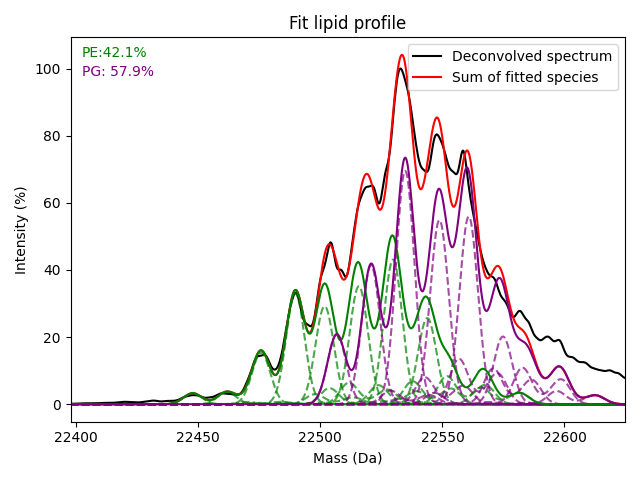

,Type,Chain,Mass,Intensity,Error,Percentage
0,PE,30:1,661.4670,3.277390,1.294121,0.708974
1,PE,31:1,675.4826,3.717225,1.299719,0.804120
2,PE,32:2,687.4826,0.442323,3.554767,0.095684
3,PE,32:1,689.4983,15.333767,3.546167,3.317042
4,PE,33:1,703.5139,32.996810,1.347997,7.137960
5,PE,34:2,715.5139,29.173589,6.895455,6.310911
6,PE,34:1,717.5296,4.782040,10.759547,1.034464
11,PG,32:1,720.4983,20.841551,5.785308,4.508501
7,PE,35:2,729.5296,35.156691,8.714269,7.605192
8,PE,35:1,731.5452,0.854729,12.504253,0.184897


,Type,Intensity,Percentage
0,PE,194.485079,42.071545
1,PG,267.787179,57.928455


In [7]:
def psf_fitting(x, a, b, c, d, e, f, g, h): 
    """
    Generate a peak shape function for a protein/protein-lipid peak.
    
    Parameters:
    -----------
    x : array-like
        Mass-to-charge (m/z) values
    a : float
        Amplitude/height
    b : float
        Center position (m/z)
    c : float
        Width parameter (standard deviation)
    d : float
        Relative abundance of first oxidation state (+16 Da)
    e : float
        Relative abundance of second oxidation state (+32 Da)
    f : float
        Relative abundance of first sodium adduct (+22 Da)
    g : float
        Relative abundance of second sodium adduct (+44 Da)
    h : float
        Relative abundance of combined oxidation-sodium adduct (+38 Da)
    
    Returns:
    --------
    array-like
        Combined intensity values
    """
    apo = a * np.exp(-((x - b) ** 2) / (2 * c ** 2)) 
    ox1 = a * d * np.exp(-((x - (b+16)) ** 2) / (2 * c ** 2)) 
    ox2 = a * e * np.exp(-((x - (b+32)) ** 2) / (2 * c ** 2)) 
    sod1 = a * f * np.exp(-((x - (b+22)) ** 2) / (2 * c ** 2))
    sod2 = a * g * np.exp(-((x - (b+44)) ** 2) / (2 * c ** 2))
    ox1sod1 = a * h * np.exp(-((x - (b+38)) ** 2) / (2 * c ** 2))
    
    # Return the sum
    return apo + ox1 + ox2 + sod1 + sod2 + ox1sod1


def sum_of_psfs(x, *amplitudes):
    """
    Combine multiple peak shape functions with shared modification parameters.
    
    Parameters:
    -----------
    x : array-like
        Mass-to-charge (m/z) values
    *amplitudes : float
        Amplitude for each peak
        
    Returns:
    --------
    array-like
        Combined intensity values
    """
    global centers, widths, params
    
    result = np.zeros_like(x)
    
    for i, amplitude in enumerate(amplitudes):
        result += psf_fitting(x, 
                             amplitude,
                             centers[i],
                             widths[i],
                             params[0],
                             params[1],
                             params[2],
                             params[3],
                             params[4])
    
    return result


def fit_lipid_profile(ms1_df, overview_df, peak_center, fwhm, min_intensity=0):
    """
    Fit multiple protein-lipid complexes to MS1 data.
    
    Parameters:
    -----------
    ms1_df : DataFrame
        MS1 data with 'x' (mass) and 'y' (intensity) columns
    overview_df : DataFrame
        DataFrame with lipid information
    peak_center : float
        Center of the apoprotein peak
    fwhm : float
        Full width at half maximum for the peaks
    min_intensity : float, optional
        Minimum intensity threshold for including peaks
        
    Returns:
    --------
    tuple
        (fitted_parameters, centers, fitted_intensities, n_pe)
    """
    global centers, widths, params
    
    pe_mask = overview_df['initial guess PE'] > min_intensity
    pe_amplitudes = list(overview_df.loc[pe_mask, 'initial guess PE'])
    pe_centers = list(overview_df.loc[pe_mask, 'complex mass PE'])
    
    pg_mask = overview_df['initial guess PG'] > min_intensity
    pg_amplitudes = list(overview_df.loc[pg_mask, 'initial guess PG'])
    pg_centers = list(overview_df.loc[pg_mask, 'complex mass PG'])
    
    amplitudes = pe_amplitudes + pg_amplitudes
    centers = pe_centers + pg_centers
    n_pe = len(pe_centers)
    
    widths = [fwhm / 2.355] * len(centers)
    
    min_x = min(centers) - 50
    max_x = max(centers) + 50
    
    lower_bounds = []
    upper_bounds = []
    initial_guesses = []
    
    # Bounds based on initial guesses (one order of magnitude range)
    for i, amplitude in enumerate(amplitudes):
        initial_guesses.append(amplitude)
        lower_bounds.append(max(0.1, amplitude * 0.1))  # Ensure positive
        upper_bounds.append(amplitude * 10)

    boundpeaks_x = ms1_df['x'].values[::5]  
    boundpeaks_y = ms1_df['y'].values[::5]
    
    mask = (boundpeaks_x >= min_x) & (boundpeaks_x <= max_x)
    boundpeaks_x = boundpeaks_x[mask]
    boundpeaks_y = boundpeaks_y[mask]
    
    try:
        popt, pcov = curve_fit(sum_of_psfs, boundpeaks_x, boundpeaks_y, 
                              p0=initial_guesses, 
                              bounds=(lower_bounds, upper_bounds),
                              maxfev=10000)
        
        perr = np.sqrt(np.diag(pcov))
        
        return popt, centers, widths, n_pe, perr
        
    except RuntimeError as e:
        print(f"Fitting error: {e}")
    
        return initial_guesses, centers, widths, n_pe, perr

    
def plot_fitted_lipid_profile(ms1_df, popt, centers, widths, n_pe, x_range=None):
    """
    Plot the fitted lipid profile.
    
    Parameters:
    -----------
    ms1_df : DataFrame
        MS1 data
    popt : array-like
        Fitted amplitudes
    centers : list
        Peak centers
    widths : list
        Peak widths
    n_pe : int
        Number of PE peaks
    x_range : tuple, optional
        (min_x, max_x) for plotting
    """
    global params
    
    if x_range is None:
        min_x = min(centers) - 50
        max_x = max(centers) + 50
    else:
        min_x, max_x = x_range
    
    mask = (ms1_df['x'] >= min_x) & (ms1_df['x'] <= max_x)
    plot_x = ms1_df.loc[mask, 'x'].values
    plot_y = ms1_df.loc[mask, 'y'].values
    
    spec_x = np.linspace(min_x, max_x, 1000)
    
    plt.figure()
    
    plt.plot(plot_x, plot_y, color='black', label='Deconvolved spectrum')
    plt.plot(spec_x, sum_of_psfs(spec_x, *popt), color='red',
             label='Sum of fitted species')
    
    # Plot individual components
    pe_sum = np.zeros_like(spec_x)
    pg_sum = np.zeros_like(spec_x)
    
    for i, amplitude in enumerate(popt):
        individual_psf = psf_fitting(spec_x, amplitude, centers[i], widths[i], 
                                    *params)
        if i < n_pe:
            color = 'green'
            label = f'PE {i}' if i == 0 else None
            pe_sum += individual_psf
        else:
            color = 'purple'
            label = f'PG {i - n_pe}' if i == n_pe else None
            pg_sum += individual_psf
            
        plt.plot(spec_x, individual_psf, color=color, linestyle='--', 
                alpha=0.7)

    plt.plot(spec_x, pe_sum, color='green')
    plt.plot(spec_x, pg_sum, color='purple')
    
    pe_total = np.sum([popt[i] for i in range(n_pe)])
    pg_total = np.sum([popt[i] for i in range(n_pe, len(popt))])
    total = pe_total + pg_total

    plt.annotate(f'PE:{pe_total/total*100:.1f}%', 
                xy=(0.02, 0.95), xycoords='axes fraction', color='green')
    plt.annotate(f'PG: {pg_total/total*100:.1f}%', 
                xy=(0.02, 0.90), xycoords='axes fraction', color='purple')
    
    plt.xlabel('Mass (Da)')
    plt.ylabel('Intensity (%)')
    plt.title('Fit lipid profile')
    plt.legend(loc='upper right')
    plt.xlim(min_x, max_x)
    plt.tight_layout()
    plt.show()
    
    return pe_sum, pg_sum

popt, centers, widths, n_pe, perr = fit_lipid_profile(ms1_df, overview_df, peak_center, fwhm=fwhm)

pe_sum, pg_sum = plot_fitted_lipid_profile(ms1_df, popt, centers, widths, n_pe)

results = []
for i, (amplitude, center) in enumerate(zip(popt, centers)):
    lipid_type = "PE" if i < n_pe else "PG"
    lipid_idx = i if i < n_pe else (i - n_pe)
    
    if lipid_type == "PE" and lipid_idx < sum(overview_df['initial guess PE'] > 0):
        chain = overview_df.loc[overview_df['initial guess PE'] > 0, 'chain'].iloc[lipid_idx]
    elif lipid_type == "PG" and lipid_idx < sum(overview_df['initial guess PG'] > 0):
        chain = overview_df.loc[overview_df['initial guess PG'] > 0, 'chain'].iloc[lipid_idx]
    else:
        chain = "Unknown"
    
    results.append({
        'Type': lipid_type,
        'Chain': chain,
        'Mass': center - peak_center,
        'Intensity': amplitude,
        'Error': perr[i] if 'perr' in locals() else 0,
        'Percentage': (amplitude / sum(popt) * 100)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Mass')
display(results_df)

type_summary = results_df.groupby('Type').agg({
    'Intensity': 'sum',
    'Percentage': 'sum'
}).reset_index()

display(type_summary)

# Save results if needed
results_df.to_csv('lipid_fitting_results.csv', index=False)